In [28]:
# necessary imports
import pandas as pd
import os
#import matplotlib.pyplot as plt
import plotly.graph_objects as go # https://plot.ly/python/choropleth-maps/

# for enhanced plotting
# https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu
import plotly
import plotly.offline as offline
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [33]:
def loadIndicatorData(dir = '', idct = ''):
    df = pd.read_csv('./ut-health-project/data/' + dir + '/' + idct + '.csv')
    if 'geoId' in df.columns:
        df = df.drop(columns = ['geoId'], axis = 1) 
    
    return df

def loadBCHIData():
    bchi_df = pd.read_csv('./ut-health-project/data/BCHI-dataset_2019-03-04.csv')
    bchi_df = bchi_df.drop(columns = ['BCHC Requested Methodology', 'Source', 'Methods', 'Notes', '90% Confidence Level - Low', '90% Confidence Level - High', '95% Confidence Level - Low', '95% Confidence Level - High'], axis = 1)

    return bchi_df

In [46]:


def plotOnUSMap(locs, values, title, maintext):
    '''
        needs a 'code' column in the dataframe (e.g. states) -> @param locs
    '''
    fig = go.Figure(data = go.Choropleth(
        locations = locs,
        z = values.astype(float),
        locationmode = 'USA-states',
        colorscale = 'Reds',
        colorbar_title = title
    ))

    fig.update_layout(
        title_text = maintext,
        geo_scope = 'usa', # limits map scope to USA
    )

    #fig.show()
    return fig

def plotOnUSMapWithSlider(df, title, maintext):
    data_slider = []
    steps = [] # slider steps
    years = df.year.unique()

    for year in years:
        df_per_year = df[(df.year == year)]
        data_of_year = dict(
            type = 'choropleth',
            locations = df_per_year['state_abbr'],
            z = df_per_year['value'].astype(float),
            colorscale = 'Reds',
            colorbar_title = title
        )

        data_slider.append(data_of_year)

    for i in range(len(data_slider)):
        step = dict(method='restyle',
                    args=['visible', [False] * len(data_slider)],
                    label='Year {}'.format(i + 2010)) # label to be displayed for each step (year)
        step['args'][1][i] = True
        steps.append(step)

    sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

    layout = dict(geo=dict(scope='usa'),
              sliders=sliders)

    # I create the figure object:
    fig = dict(data=data_slider, layout=layout) 

    return fig

In [12]:
# Life Expectancy, USA, Years: 2010, 2014
life_expectancy_total_1014 = loadIndicatorData('life-expectancy', 'life-expectancy')
life_expectancy_total_1014.head()

# Life Expectancy, USA, Years: 1900 - 2017
life_expectancy_total = loadIndicatorData('life-expectancy', 'life_expectancy_total')
#life_expectancy_total.head(25)

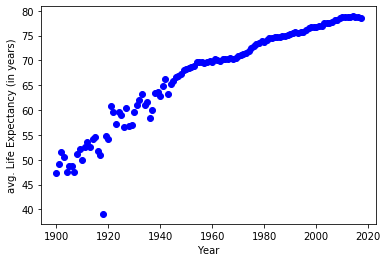

In [13]:
plot_data = life_expectancy_total[(life_expectancy_total.Race == 'All Races') & (life_expectancy_total.Sex == 'Both Sexes')] 
plt.plot(plot_data['Year'], plot_data['Average Life Expectancy (Years)'], 'bo')
plt.ylabel('avg. Life Expectancy (in years)')
plt.xlabel('Year')
plt.show()

In [14]:
plot_data.tail(10)

,Year,Race,Sex,Average Life Expectancy (Years),Age-adjusted Death Rate
108,2008,All Races,Both Sexes,78.2,774.9
109,2009,All Races,Both Sexes,78.5,749.6
110,2010,All Races,Both Sexes,78.7,747.0
111,2011,All Races,Both Sexes,78.7,741.3
112,2012,All Races,Both Sexes,78.8,732.8
113,2013,All Races,Both Sexes,78.8,731.9
114,2014,All Races,Both Sexes,78.9,724.6
115,2015,All Races,Both Sexes,78.7,733.1
116,2016,All Races,Both Sexes,78.7,728.8
117,2017,All Races,Both Sexes,78.6,731.9


Volatile in the beginning (outlier: 1918), but since the 1950 the life expectancy increases (up until 2016), then it starts to decline a bit. As a side remark: in 2016 the global life expectancy was 72 years (WHO).
Let's check now for the LE within the USA.

In [15]:
# Average LE per area, Years: 2010, 2014
life_expectancy_total_1014_grouped = life_expectancy_total_1014.groupby(['metro_nonmetro', 'year'], as_index = False).mean()
life_expectancy_total_1014_grouped = life_expectancy_total_1014_grouped.append(pd.DataFrame({"metro_nonmetro":["USA", "USA"], "year":[2010, 2014], "value":[78.7, 78.9]}), ignore_index = True) # add data for USA total

In [16]:
life_expectancy_total_1014_grouped

,metro_nonmetro,year,value
0,Metropolitan,2010,78.121184
1,Metropolitan,2014,78.227539
2,Nonmetropolitan,2010,77.449970
3,Nonmetropolitan,2014,77.469266
4,USA,2010,78.700000
5,USA,2014,78.900000


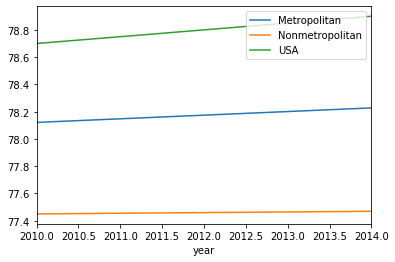

In [17]:
# TODO work out a better chart

fig, ax = plt.subplots()
for label, grp in life_expectancy_total_1014_grouped.groupby('metro_nonmetro'):
    grp.plot(x = 'year', y = 'value', ax = ax, label = label, kind = 'line')

Only spares data is available, so we have to resort to other measures, e.g. the median age for each state, from 2010 to 2017.

In [18]:
median_age_per_state = loadIndicatorData(dir = 'median-age', idct = 'median-age')
median_age_per_state

,metro_nonmetro,year,county_name,state_abbr,value
0,Metropolitan,2010,Anchorage Municipality,AK,32.8
1,Metropolitan,2010,Fairbanks North Star Borough,AK,30.9
2,Metropolitan,2010,Matanuska-Susitna Borough,AK,34.7
3,Metropolitan,2010,Autauga County,AL,37.1
4,Metropolitan,2010,Baldwin County,AL,41.2
...,...,...,...,...,...
25131,Nonmetropolitan,2017,Sweetwater County,WY,32.8
25132,Nonmetropolitan,2017,Teton County,WY,36.5
25133,Nonmetropolitan,2017,Uinta County,WY,33.8
25134,Nonmetropolitan,2017,Washakie County,WY,42.9


In [32]:
plotly.offline.iplot(plotOnUSMap(median_age_per_state['state_abbr'], median_age_per_state['value'], 'Median Age', 'My First Choropleth'))

In [47]:
plotly.offline.iplot(plotOnUSMapWithSlider(median_age_per_state, 'Median Age', 'map with slider'))